In [42]:
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt

# Własne funkcje kosztu

G - goal
H - hole

In [2]:
def reward_func0(env, field):
    if env.desc[field] == b'G':
        return 1
    else:
        return 0

def reward_func1(env, field):
    if env.desc[field] == b'G':
        return 1
    elif env.desc[field] == b'H':
        return -1
    else:
        return 0

def reward_func2(env, field):
    if env.desc[field] == b'G':
        return 5
    elif env.desc[field] == b'H':
        return -1
    else:
        return 0

In [3]:
MAX_ACTIONS = 200

def train(env, func, total_episodes = 10000, lr = 0.1, gamma = 0.99):

    n_observations = env.observation_space.n
    n_actions = env.action_space.n

    qtable = np.zeros((n_observations, n_actions))

    # Exploration parameters
    epsilon = 1.0                 # Exploration rate
    max_epsilon = 1.0             # Exploration probability at start
    min_epsilon = 0.01            # Minimum exploration probability 
    decay_rate = 0.001            # Exponential decay rate for exploration prob


    for _ in range(total_episodes):
        current_state = env.reset()

        done = False
        total_episode_reward = 0
        for step in range(MAX_ACTIONS):

            if np.random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(qtable[current_state,:])

            next_state, reward_default, done, _ = env.step(action)
            field = divmod(next_state, 8)
            reward = func(env, field)

            qtable[current_state, action] = qtable[current_state, action] + lr * (reward + gamma * np.max(qtable[next_state, :]) - qtable[current_state, action])
            total_episode_reward += reward_default

            if done:
                break
            current_state = next_state

        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*step) 
    return qtable

def test(env, qt, iters):
    a = []

    for _ in range(iters):
        done = False
        current_state = env.reset()

        for _ in range(MAX_ACTIONS):
            action = np.argmax(qt[current_state,:])
            next_state, reward, done, _ = env.step(action)

            if done:
                break
            current_state = next_state
        a.append(reward)
    return sum(a)/iters*100



# TESTY
porównanie funckji kosztu

In [4]:
functions = [reward_func0, reward_func1, reward_func2]

env = gym.make("FrozenLake8x8-v1")
total_episodes = 10000


test_data = pd.read_csv("test_data.csv")

for i in range(len(functions)):
    for _ in range(10):
        qt = train(env, functions[i], total_episodes)
        succes_rate_test = test(env, qt, int(total_episodes/10))
        test_data = pd.concat([test_data, pd.DataFrame(data={"function": [i], "succes_rate": [succes_rate_test]})])
    test_data.to_csv("test_data.csv")


In [40]:
f0_avg = sum(test_data[test_data['function'] == 0]['succes_rate'])/len(test_data[test_data['function'] == 0])
f1_avg = sum(test_data[test_data['function'] == 1]['succes_rate'])/len(test_data[test_data['function'] == 1])
f2_avg = sum(test_data[test_data['function'] == 2]['succes_rate'])/len(test_data[test_data['function'] == 2])

<BarContainer object of 3 artists>

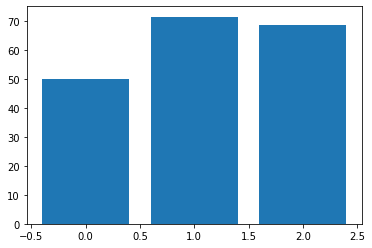

In [47]:
plt.bar(test_data['function'].unique(), np.array([f0_avg, f1_avg, f2_avg]))

porównanie całkowitej liczby epizodów

In [ ]:
succes_rate_test_vs_total_episodes = np.zeros((5,3))

for j in range(len(functions)):
    for i in range(1, 6):
        total_episodes = 10 ** i
        qt = train(env, functions[j], total_episodes)
        succes_rate_test_vs_total_episodes[i-1,j] = test(env, qt, int(total_episodes/10))

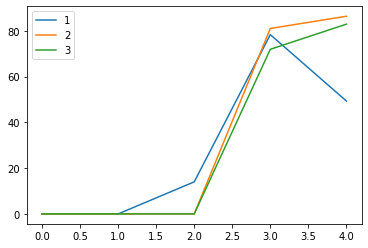

In [70]:
plt.plot(succes_rate_test_vs_total_episodes)
plt.legend(['1','2','3'])

# WNIOSKI

* funkcja 1 jest najlepsza
* karanie za nieunikanie punktów 'H' pooprawia rozwiązanie
*  większa ilośc prób poprawia ilość zwycięstw